# Imports

In [23]:
import tensorflow as tf
from keras import backend as K

import matplotlib.pyplot as plt
import numpy as np

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output
from pathlib import Path
import random

In [24]:
def get_random_file(directory):
    files = [f for f in directory.glob('**/*') if f.is_file()]
    return random.choice(files) if files else None

# Directories for content and style images
content_directory = Path('C:\\AItoArtGenerator\\Testing Data')
style_directory = Path('C:\\AItoArtGenerator\\artStyle')

# Get a random content and style image
content_path = get_random_file(content_directory)
style_path = get_random_file(style_directory)

# Display the chosen paths
print(f'Random Content Path: {content_path}')
print(f'Random Style Path: {style_path}')

Random Content Path: C:\AItoArtGenerator\Testing Data\Coast\Coast-Test (164).jpeg
Random Style Path: C:\AItoArtGenerator\artStyle\Vincent_van_Gogh\Vincent_van_Gogh_545.jpg


In [25]:
def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 512
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image

def load_images(content_path, style_path):
  '''loads the content and path images as tensors'''
  content_image = load_img("{}".format(content_path))
  style_image = load_img("{}".format(style_path))

  return content_image, style_image
  
def imshow(image, title=None):
  '''displays an image with a corresponding title'''
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def show_images_with_objects(images, titles=[]):
  '''displays a row of images with corresponding titles'''
  if len(images) != len(titles):
    return

  plt.figure(figsize=(20, 12))
  for idx, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1, len(images), idx + 1)
    plt.xticks([])
    plt.yticks([])
    imshow(image, title)  

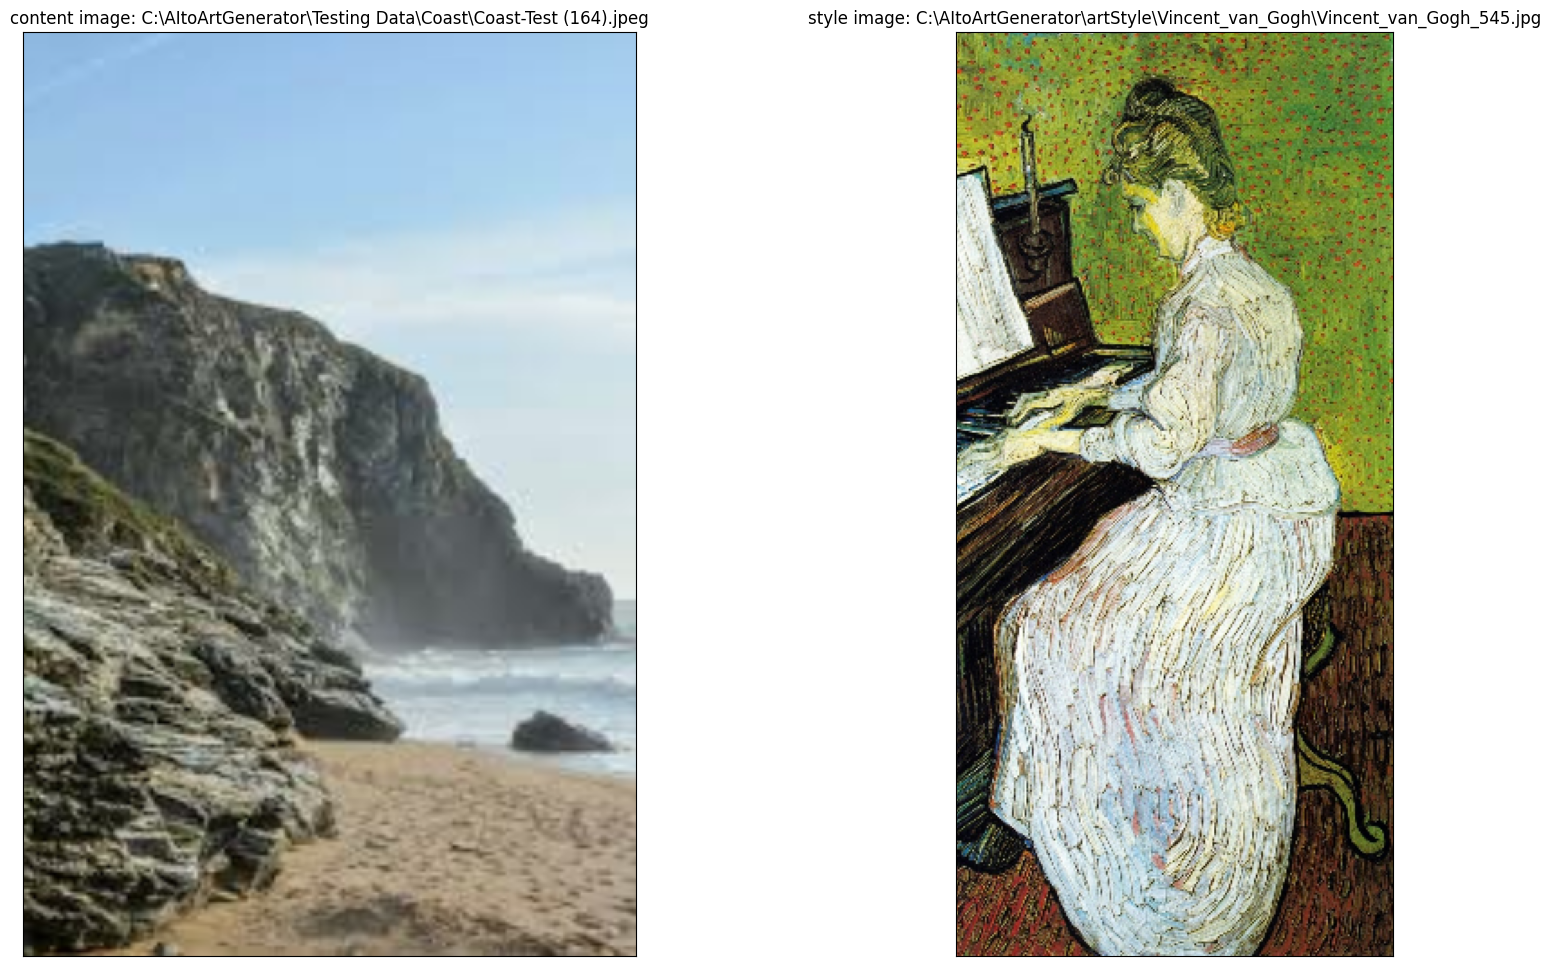

In [26]:
# display the content and style image
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image], 
                         titles=[f'content image: {content_path}',
                                 f'style image: {style_path}'])

# Build the feature extractor

We will inspect the layers of the Inception model.

In [27]:
# clear session to make layer naming consistent when re-running this cell
K.clear_session()

# download the inception model and inspect the layers
tmp_inception = tf.keras.applications.InceptionV3()
tmp_inception.summary()

# delete temporary model
del tmp_inception

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

As you can see, it's a very deep network and compared to VGG-19, it's harder to choose which layers to choose to extract features from.

Notice that the Conv2D layers are named from conv2d, conv2d_1 ... conv2d_93, for a total of 94 conv2d layers.
So the second conv2D layer is named conv2d_1.

We choose the following:

* For the content layer: the Conv2D layer indexed at 88.
* For the style layers: the first five conv2D layers near the input end of the model.

In [28]:
# choose the content layer and put in a list
content_layers = ['conv2d_93']

# choose the five style layers of interest
style_layers = ['conv2d', 
                'conv2d_1', 
                'conv2d_2', 
                'conv2d_3', 
                'conv2d_4']

# combine the content and style layers into one list
content_and_style_layers = style_layers + content_layers 

# count the number of content layers and style layers.
NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

We can now setup our model to output the selected layers.

In [29]:
def inception_model(layer_names):

  # Load InceptionV3 with the imagenet weights and **without** the 3 fully-connected layers at the top of the network
  inception = tf.keras.applications.inception_v3.InceptionV3(include_top = False, weights= 'imagenet')

  # Freeze the weights of the model's layers (make them not trainable)
  inception.trainable = False
  
  # Create a list of layer objects that are specified by layer_names
  output_layers = [inception.get_layer(name).output for name in layer_names]

  # Create the model that outputs the content and style layers
  model = tf.keras.models.Model(inputs = inception.input, outputs = output_layers)
    
  # return the model
  return model

Create an instance of the content and style model using the function that you just defined

In [30]:
K.clear_session()

inception = inception_model(content_and_style_layers)
inception 

# Calculate style loss

The style loss is the average of the squared differences between the features and targets.

In [31]:
def get_style_loss(features, targets):

  # Calculate the style loss
  style_loss =  tf.reduce_mean(tf.square(features - targets)) 
    
  return style_loss

# Calculate content loss

Calculate the sum of the squared error between the features and targets, then multiply by a scaling factor (0.5).

In [32]:
def get_content_loss(features, targets):
  # get the sum of the squared error multiplied by a scaling factor
  content_loss =  0.5 * tf.reduce_sum(tf.square(features - targets))
    
  return content_loss

# Calculate the gram matrix

In [33]:
def gram_matrix(input_tensor):

  # calculate the gram matrix of the input tensor
  gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

  # get the height and width of the input tensor
  input_shape = tf.shape(input_tensor) 
  height = input_shape[1] 
  width = input_shape[2] 

  # get the number of locations (height times width), and cast it as a tf.float32
  num_locations = tf.cast(height * width, tf.float32)

  # scale the gram matrix by dividing by the number of locations
  scaled_gram = gram / num_locations
    
  return scaled_gram

# Get the style image features

Given the style image as input, you'll get the style features of the inception model that you just created using inception_model().

We'll first preprocess the image using the preprocess_image function.

We'll then get the outputs of the model.

From the outputs, we just get the style feature layers and not the content feature layer.

In [34]:
tmp_layer_list = [layer.output for layer in inception.layers]
tmp_layer_list

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'activation')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, None, None, 32) dtype=float32 (created by layer 'activation_1')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'batch_normalization_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32 (created by layer 'activation_2')>,
 <KerasTensor: shape=(None, None, None, 64) dtype=float32

For each style layer, calculate the gram matrix. Store these results in a list and return it.

In [35]:
def preprocess_image(image):
  image = tf.cast(image, dtype=tf.float32)
  image = (image / 127.5) - 1.0

  return image

In [36]:
def get_style_image_features(image):  

  # preprocess the image using the given preprocessing function
  preprocessed_style_image = preprocess_image(image) 

  # get the outputs from the inception model that you created using inception_model()
  outputs = inception(preprocessed_style_image) 

  # Get just the style feature layers (exclude the content layer)
  style_outputs = outputs[:NUM_STYLE_LAYERS]

  # for each style layer, calculate the gram matrix for that layer and store these results in a list
  gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]

  return gram_style_features

# Get content image features

In [37]:
def get_content_image_features(image):

  # preprocess the image
  preprocessed_content_image = preprocess_image(image)
    
  # get the outputs from the inception model
  outputs = inception(preprocessed_content_image)

  # get the content layer of the outputs
  content_outputs = outputs[NUM_STYLE_LAYERS:]

  return content_outputs

# Calculate the total loss

$L_{total} = \beta L_{style} + \alpha L_{content}$

In [38]:
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, style_weight, content_weight):

  # Sum of the style losses
  style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])
  
  # Sum up the content losses
  content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])

  # scale the style loss by multiplying by the style weight and dividing by the number of style layers
  style_loss =  style_loss * style_weight / NUM_STYLE_LAYERS

  # scale the content loss by multiplying by the content weight and dividing by the number of content layers
  content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS 
    
  # sum up the style and content losses
  total_loss = style_loss + content_loss 

  # return the total loss
  return total_loss

# Calculate gradients

We use tf.GradientTape() to get the gradients of the loss with respect to the input image.

In [39]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight):

  with tf.GradientTape() as tape:
      
    # get the style image features
    style_features = get_style_image_features(image) 
      
    # get the content image features
    content_features = get_content_image_features(image) 
      
    # get the style and content loss
    loss =  get_style_content_loss(style_targets, style_features, content_targets, 
                                  content_features, style_weight, content_weight) 

  # calculate gradients of loss with respect to the image
  gradients = tape.gradient(loss, image) 

  return gradients

# Update the image with the style

In [40]:
def clip_image_values(image, min_value=0.0, max_value=255.0):
 
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)

In [41]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            content_weight, optimizer):
  # Calculate gradients using the function that you just defined.
  gradients = calculate_gradients(image, style_targets, content_targets, 
                                  style_weight, content_weight) 

  # apply the gradients to the given image
  optimizer.apply_gradients([(gradients, image)])

  # Clip the image using the given clip_image_values() function
  image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

# Generate the stylized image

In [42]:
def tensor_to_image(tensor):
  '''converts a tensor to an image'''
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 

In [43]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       optimizer='adam', epochs=1, steps_per_epoch=1):

  images = []
  step = 0

  # get the style image features 
  style_targets = get_style_image_features(style_image)
    
  # get the content image features
  content_targets = get_content_image_features(content_image)

  # initialize the generated image for updates
  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image) 
  
  # collect the image updates starting from the content image
  images.append(content_image)
  
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
    
      # Update the image with the style using the function that we defined
      update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weight, content_weight, optimizer)
      
      print(".", end='')
      if (m + 1) % 10 == 0:
        images.append(generated_image)
    
    # display the current stylized image
    clear_output(wait=True)
    display_image = tensor_to_image(generated_image)
    display_fn(display_image)

    # append to the image collection for visualization later
    images.append(generated_image)
    print("Train step: {}".format(step))
  
  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
  generated_image = tf.cast(generated_image, dtype=tf.uint8)
  
  return generated_image, images

With all the functions defined, we can now run the main loop and generate the stylized image. 

In [44]:
# define style and content weight
style_weight =  0.35
content_weight = 1e-32 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80))

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)

With higher style weight

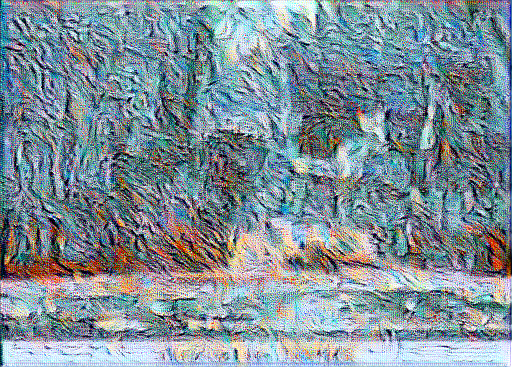

Train step: 1000


In [ ]:
# define style and content weight
style_weight =  0.8
content_weight = 1e-32 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=80.0, decay_steps=100, decay_rate=0.80))

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    optimizer=adam, epochs=10, steps_per_epoch=100)

If you want to try different images, you may need to change the content and style weight for better results (specially the style weight.)